<a href="https://colab.research.google.com/github/nourhatem2004/California-Housing-Prices-prediction-and-data-analysis/blob/main/California_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **California Housing Price Prediction & Analysis Project**
The goal of this project is to analyze Calfornia Housing Listings, extract key features, and predict listing prices using machine learning.

First we import necessary libraries:

In [15]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Then we import the dataset:

In [2]:
house_price_dataset = sklearn.datasets.fetch_california_housing()
df = pd.DataFrame(house_price_dataset.data, columns = house_price_dataset.feature_names)
df['price'] = house_price_dataset.target
print(df.head())
print(df.shape)

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  
(20640, 9)


Now lets get our data ready for processing:

In [3]:
print(df.isna().sum())

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
price         0
dtype: int64


We can do some feature engineering, but lets plot first to get an idea:

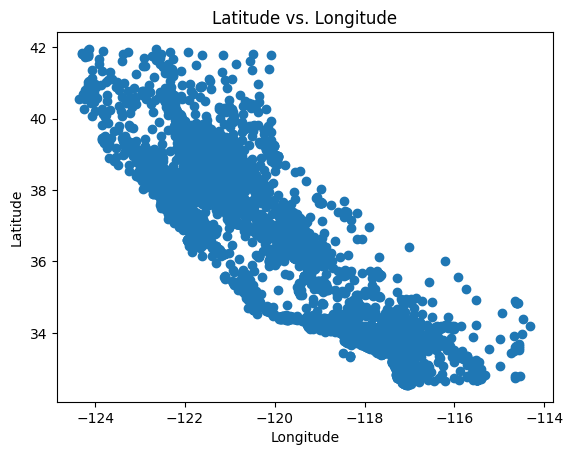

In [4]:
lat_lon = df[['Latitude', 'Longitude']]

plt.scatter(df['Longitude'], df['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Latitude vs. Longitude')
plt.show()

We can extract another feature which is the distance to the nearest major city, I found the coordinates of the top 10 major cities in california and here is how we apply it to the dataset:

In [5]:
from geopy.distance import geodesic

major_cities = {
    "San Francisco": (37.7749, -122.4194),
    "San Jose": (37.3382, -121.8863),
    "Oakland": (37.8044, -122.2711),
    "Los Angeles": (34.0522, -118.2437),
    "San Diego": (32.7157, -117.1611),
    "Santa Monica": (34.0195, -118.4912),
    "Palo Alto": (37.4419, -122.1430),
    "Berkeley": (37.8715, -122.2730),
    "Irvine": (33.6846, -117.8265),
    "Santa Barbara": (34.4208, -119.6982),
}

def closest_major_city(row):
    distances = {city: geodesic((row['Latitude'], row['Longitude']), coords).km for city, coords in major_cities.items()}
    nearest_city = min(distances, key=distances.get)
    nearest_distance = distances[nearest_city]
    return nearest_city, nearest_distance

df[['Nearest_major(name)', 'Nearest_major(dist)']] = df.apply(closest_major_city, axis=1, result_type='expand')
df = df.drop(columns=['Longitude', 'Latitude'])

print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  price  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556  4.526   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842  3.585   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260  3.521   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945  3.413   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467  3.422   

  Nearest_major(name)  Nearest_major(dist)  
0            Berkeley             3.899024  
1            Berkeley             4.835120  
2            Berkeley             3.758675  
3            Berkeley             3.129084  
4            Berkeley             3.129084  


Since City name is a categorical feature that doesnt have a linear relation with the price, lets get the average price of each city and assign it as a new column:

In [6]:
cities = df['Nearest_major(name)'].unique()
city_prices = {}
for city in cities:
  city_prices[city]=df.loc[df['Nearest_major(name)'] == city, 'price'].mean()
df['city_prices'] = df['Nearest_major(name)'].map(city_prices)

print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  price  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556  4.526   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842  3.585   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260  3.521   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945  3.413   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467  3.422   

  Nearest_major(name)  Nearest_major(dist)  city_prices  
0            Berkeley             3.899024     1.497699  
1            Berkeley             4.835120     1.497699  
2            Berkeley             3.758675     1.497699  
3            Berkeley             3.129084     1.497699  
4            Berkeley             3.129084     1.497699  


In [7]:

def identify_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

for col in df.select_dtypes(include=np.number).columns:
    outliers = identify_outliers(df[col])
    if not outliers.empty:
        print(f"Outliers in column '{col}':")
        print(outliers.count())
        print("-" * 20)





Outliers in column 'MedInc':
681
--------------------
Outliers in column 'AveRooms':
511
--------------------
Outliers in column 'AveBedrms':
1424
--------------------
Outliers in column 'Population':
1196
--------------------
Outliers in column 'AveOccup':
711
--------------------
Outliers in column 'price':
1071
--------------------
Outliers in column 'Nearest_major(dist)':
1684
--------------------
Outliers in column 'city_prices':
3250
--------------------


As we can see these are the number of outliers, as of now they might be normal, lets check after training to see if our results are non satisfactory, for now, lets preprocess the data:

In [8]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


print(df.head())

df.to_csv('processed_data.csv', index=False)

     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup     price  \
0  2.344766  0.982143  0.628559  -0.153758   -0.974429 -0.049597  2.129631   
1  2.332238 -0.607019  0.327041  -0.263336    0.861439 -0.092512  1.314156   
2  1.782699  1.856182  1.155620  -0.049016   -0.820777 -0.025843  1.258693   
3  0.932968  1.856182  0.156966  -0.049833   -0.766028 -0.050329  1.165100   
4 -0.012881  1.856182  0.344711  -0.032906   -0.759847 -0.085616  1.172900   

   Nearest_major(name)  Nearest_major(dist)  city_prices  
0                    0            -0.751236    -1.001706  
1                    0            -0.738099    -1.001706  
2                    0            -0.753205    -1.001706  
3                    0            -0.762041    -1.001706  
4                    0            -0.762041    -1.001706  


With our dataset ready lets start training:

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(df.drop(columns=['price']),df['price'], test_size=0.3, random_state=42)
X_test, X_cv, y_test, y_cv = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
max_degree = 5
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)

# Loop through degrees
for degree in range(max_degree):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree + 1)  # degree + 1 to start from degree 1
    X_train_poly = poly_features.fit_transform(X_train)
    X_cv_poly = poly_features.transform(X_cv)

    # Create and train the linear regression model
    lmodel = LinearRegression()
    lmodel.fit(X_train_poly, y_train)

    # Predict on training data and calculate training error
    yhat_train = lmodel.predict(X_train_poly)
    err_train[degree] = mean_squared_error(y_train, yhat_train)

    # Predict on validation data and calculate validation error
    yhat_cv = lmodel.predict(X_cv_poly)
    err_cv[degree] = mean_squared_error(y_cv, yhat_cv)

# Find the optimal degree
optimal_degree = np.argmin(err_cv) + 1  # +1 to get the actual degree (since we start from 0)

# Print the optimal degree
print(f"Optimal Degree: {optimal_degree}")


Optimal Degree: 1


Optimal Degree is 1, so we use normal Linear regression:

In [11]:
LinearModel = LinearRegression()
LinearModel.fit(X_train, y_train)
training_data_prediction = LinearModel.predict(X_train)
r2_train = metrics.r2_score(y_train, training_data_prediction)
print('R Squared value = ', r2_train)
print('Mean Absolute Error = ', metrics.mean_absolute_error(y_train, training_data_prediction))
test_data_prediction = LinearModel.predict(X_test)
r2_test = metrics.r2_score(y_test, test_data_prediction)
print('R Squared value = ', r2_test)
print('Mean Absolute Error = ', metrics.mean_absolute_error(y_test, test_data_prediction))

R Squared value =  0.628804260780697
Mean Absolute Error =  0.4556040113886291
R Squared value =  0.6062769962044814
Mean Absolute Error =  0.4562057165430408


Linear Regression produces decent results, but improvements can be made, we can try other regression models where a linear relation between the features and price isnt very necessary:

In [12]:
TreeModel = XGBRegressor()
TreeModel.fit(X_train, y_train)
training_data_prediction = TreeModel.predict(X_train)
r2_train = metrics.r2_score(y_train, training_data_prediction)
print('R Squared value = ', r2_train)
print('Mean Absolute Error = ', metrics.mean_absolute_error(y_train, training_data_prediction))
test_data_prediction = TreeModel.predict(X_test)
r2_test = metrics.r2_score(y_test, test_data_prediction)
print('R Squared value = ', r2_test)
print('Mean Absolute Error = ', metrics.mean_absolute_error(y_test, test_data_prediction))

R Squared value =  0.9324454256999191
Mean Absolute Error =  0.18450229273830243
R Squared value =  0.779747709594287
Mean Absolute Error =  0.3119069219258626


the XGB tree model works much better, why is that? XGBoost works better than linear regression because it can capture nonlinear relationships that a simple linear model cannot. It automatically handles feature interactions, reducing the need for manually engineering polynomial terms. Unlike linear regression, XGBoost is robust to outliers since tree-based methods are not as sensitive to extreme values, we can still improve it:

In [14]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

random_search = RandomizedSearchCV(TreeModel, param_grid, scoring='r2', cv=5, n_iter=10, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

TreeModel = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="rmse"
)

TreeModel.fit(
    X_train, y_train,
    eval_set=[(X_cv, y_cv)],
    verbose=True
)
r2_train = metrics.r2_score(y_train, training_data_prediction)
print('R Squared value = ', r2_train)
print('Mean Absolute Error = ', metrics.mean_absolute_error(y_train, training_data_prediction))
test_data_prediction = TreeModel.predict(X_test)
r2_test = metrics.r2_score(y_test, test_data_prediction)
print('R Squared value = ', r2_test)
print('Mean Absolute Error = ', metrics.mean_absolute_error(y_test, test_data_prediction))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-rmse:0.92555
[1]	validation_0-rmse:0.86323
[2]	validation_0-rmse:0.80798
[3]	validation_0-rmse:0.76035
[4]	validation_0-rmse:0.71734
[5]	validation_0-rmse:0.68024
[6]	validation_0-rmse:0.64931
[7]	validation_0-rmse:0.62219
[8]	validation_0-rmse:0.59727
[9]	validation_0-rmse:0.57688
[10]	validation_0-rmse:0.55900
[11]	validation_0-rmse:0.54460
[12]	validation_0-rmse:0.53051
[13]	validation_0-rmse:0.51866
[14]	validation_0-rmse:0.50824
[15]	validation_0-rmse:0.49981
[16]	validation_0-rmse:0.49286
[17]	validation_0-rmse:0.48637
[18]	validation_0-rmse:0.48056
[19]	validation_0-rmse:0.47555
[20]	validation_0-rmse:0.47067
[21]	validation_0-rmse:0.46659
[22]	validation_0-rmse:0.46305
[23]	validation_0-rmse:0.46067
[24]	validation_0-rmse:0.45820
[25]	validation_0-rmse:0.45546
[26]	validation_0-rmse:0.45361
[27]	validation_0-rmse:0.45158
[28]	validation_0-rmse:0.44976
[29]	validation_0-rmse:0.44845
[30]	validation_0-r

thats a bit better, we can also try the neural networks approach since we have alot of data:

In [26]:
class R2Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_cv)
        r2 = r2_score(y_cv, y_pred)
        print(f"Epoch {epoch + 1}: R-squared = {r2:.4f}")

r2_callback = R2Callback()
nn_model = Sequential([
    Dense(units = 16, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    Dense(units = 8, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    Dense(units = 4, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    Dense(units = 1, activation = 'linear')
])
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss in this case)
    patience=10,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored quantity.
)

nn_model.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')
nn_model.fit(X_train, y_train, epochs = 1000, batch_size = 32, validation_data = (X_cv, y_cv), callbacks=[early_stopping, r2_callback])

predictions = nn_model.predict(X_test)
r2_test = metrics.r2_score(y_test, predictions)
print('R Squared value = ', r2_test)
print('Mean Absolute Error = ', metrics.mean_absolute_error(y_test, predictions))



Epoch 1/1000
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1: R-squared = 0.6927
452/452 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.6173 - val_loss: 0.3661
Epoch 2/1000
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 2: R-squared = 0.6976
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3917 - val_loss: 0.3479
Epoch 3/1000
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: R-squared = 0.6979
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3780 - val_loss: 0.3431
Epoch 4/1000
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 4: R-squared = 0.7165
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3543 - val_loss: 0.3242
Epoch 5/1000
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 5: R-squared = 0.6736
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3395 - val_loss: 0.3666
Epoch 6/1000
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 6: R-squared = 0.7047
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3575 - val_loss: 0.3340
Epoch 7/1000
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 7: R-squared

Not bad but the tree solution would be better of course.